In [5]:
import pandas as pd
from lib.llm_utils import PROMPT_TYPES

merged_df = pd.read_csv('data_samples/short-answers-10k.csv')
data_df = pd.read_csv('data_samples/askme-10k.csv')

rating_columns = {
    '1_word_answer_rating_score': '1 word',
    '2_words_answer_rating_score': '2 word',
    '3_words_answer_rating_score': '3 word',
    '4_words_answer_rating_score': '4 word',
    '5_words_answer_rating_score': '5 word',
    'few_words_answer_rating_score': 'few word',
}
answer_columns = [prompt + '_answer_text' for prompt in PROMPT_TYPES]
rating_data = merged_df[list(rating_columns.keys()) + answer_columns].rename(columns=rating_columns)
rating_only_data = rating_data[list(rating_columns.values())]
rating_stats = rating_data.describe().T[['mean', 'std']]

golden_answer_mean = data_df['value'].mean()
golden_answer_std = data_df['value'].std()
rating_stats.loc['golden answer'] = [golden_answer_mean, golden_answer_std]
word_counts = rating_data[answer_columns].applymap(lambda x: len(str(x).split()))
word_counts.columns = [column.split("_")[0] + ' word' for column in word_counts.columns]
word_count_stats = word_counts.describe().T[['mean', 'std']]

defiant = []
for column in word_counts.columns:
    limit = column.split()[0]
    if limit == 'few':
        continue
    ratio = (word_counts[column] > int(limit)).sum() / len(word_counts) * 100
    defiant.append(ratio)
defiant.extend(["N/A", "N/A"])

golden_answer_word_count = data_df['text'].apply(lambda x: len(str(x).split()))
word_count_stats.loc['golden answer'] = [golden_answer_word_count.mean(), golden_answer_word_count.std()]
word_count_stats['% defiant'] = defiant

combined_stats = pd.concat([rating_stats, word_count_stats], axis=1, keys=['Rating Stats', 'Word Count Stats'])
combined_stats

/tmp/ipykernel_155747/919176418.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  word_counts = rating_data[answer_columns].applymap(lambda x: len(str(x).split()))


Rating Stats           Word Count Stats                     
                      mean       std             mean        std % defiant
1 word              3.8803  1.255997           1.1496   1.081821       7.1
2 word              4.1725  1.118691           1.4704   0.960217      4.14
3 word              4.4209  0.937993           1.9658   0.824923      1.32
4 word              4.5981  0.762781           2.5549   0.943544      0.87
5 word              4.7029  0.635824           3.0260   1.255819      0.72
few word            4.8892  0.401920           5.8300   6.699133       N/A
golden answer       4.9374  0.301480          17.3093  10.550923       N/A

In [6]:
for column in word_counts.columns:
    limit = column.split()[0]
    if limit == 'few':
        continue
    # calculate the ratio of number of answers that exceed the limit
    ratio = (word_counts[column] > int(limit)).sum() / len(word_counts) * 100
    print(f"Ratio of answers with more than {limit} words: {ratio:.2f}%")


Ratio of answers with more than 5 words: 0.72%
Ratio of answers with more than 4 words: 0.87%
Ratio of answers with more than 3 words: 1.32%
Ratio of answers with more than 2 words: 4.14%
Ratio of answers with more than 1 words: 7.10%


/tmp/ipykernel_155747/3348295160.py:23: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  rating_for_plot = rating_data[rating_columns.values()].apply(pd.value_counts).fillna(0)
/tmp/ipykernel_155747/3348295160.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data.index, rotation=45, ha='right')


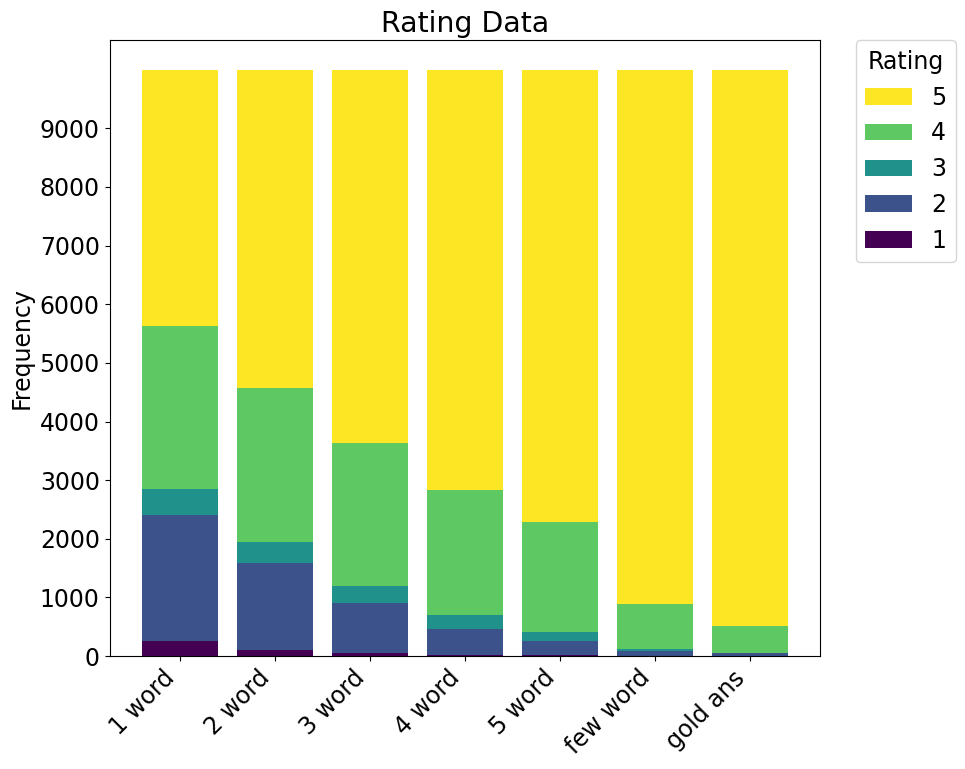

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def plot_stacked_bar_chart(data, columns, title, ylabel, color_legend, ticks=None):
    colors = plt.cm.viridis(np.linspace(0, 1, 5)) 
    plt.rcParams.update({'font.size': 17})

    fig, ax = plt.subplots(figsize=(10, 8))
    bottom_values = np.zeros(len(data.index))
    for i, column in enumerate(columns):
        ax.bar(data.index, data[column], bottom=bottom_values, label=column, color=colors[i])
        bottom_values += data[column]
    
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(title=color_legend, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, reverse=True)
    ax.set_xticklabels(data.index, rotation=45, ha='right')
    if ticks:
        ax.set_yticks(ticks)
    plt.tight_layout()
    plt.show()

rating_for_plot = rating_data[rating_columns.values()].apply(pd.value_counts).fillna(0)
rating_for_plot['golden answer'] = data_df['value'].value_counts().reindex(rating_for_plot.index).fillna(0)
rating_for_plot.rename(columns={'golden answer': 'gold ans'}, inplace=True)
rating_for_plot = rating_for_plot.T[:7]

word_counts['golden answer'] = golden_answer_word_count
word_counts.rename(columns={'golden answer': 'gold ans'}, inplace=True)
word_count_for_plot = word_counts.T[:7]
word_count_for_plot = pd.concat([word_count_for_plot[:5][::-1], word_count_for_plot[5:]])

plot_stacked_bar_chart(rating_for_plot, [1, 2, 3, 4, 5], 'Rating Data', 'Frequency', 'Rating', ticks=list(np.arange(0, 10_000, 1000)))
#plot_stacked_bar_chart(word_count_for_plot, [1, 2, 3, 4, 5], 'Word Count Data', 'Frequency', 'Answer Length', ticks=list(np.arange(0, 10, 1)) + list(np.arange(10, 81, 10)))

In [43]:
word_count_for_plot

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
1 word,1,2,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,2
2 word,1,2,2,1,1,1,1,1,1,2,...,1,2,2,2,2,1,1,1,2,2
3 word,2,2,2,1,2,1,2,2,2,2,...,1,2,2,2,2,2,2,2,4,2
4 word,3,3,2,2,2,1,2,2,3,3,...,1,2,2,3,2,3,3,4,4,3
5 word,3,5,4,2,2,1,2,3,3,4,...,1,2,3,4,2,3,3,4,4,3
few word,3,25,5,1,3,1,3,3,3,9,...,1,2,5,12,2,12,3,4,10,6
gold ans,16,9,19,20,10,20,17,24,17,22,...,4,23,16,12,16,14,13,20,7,28


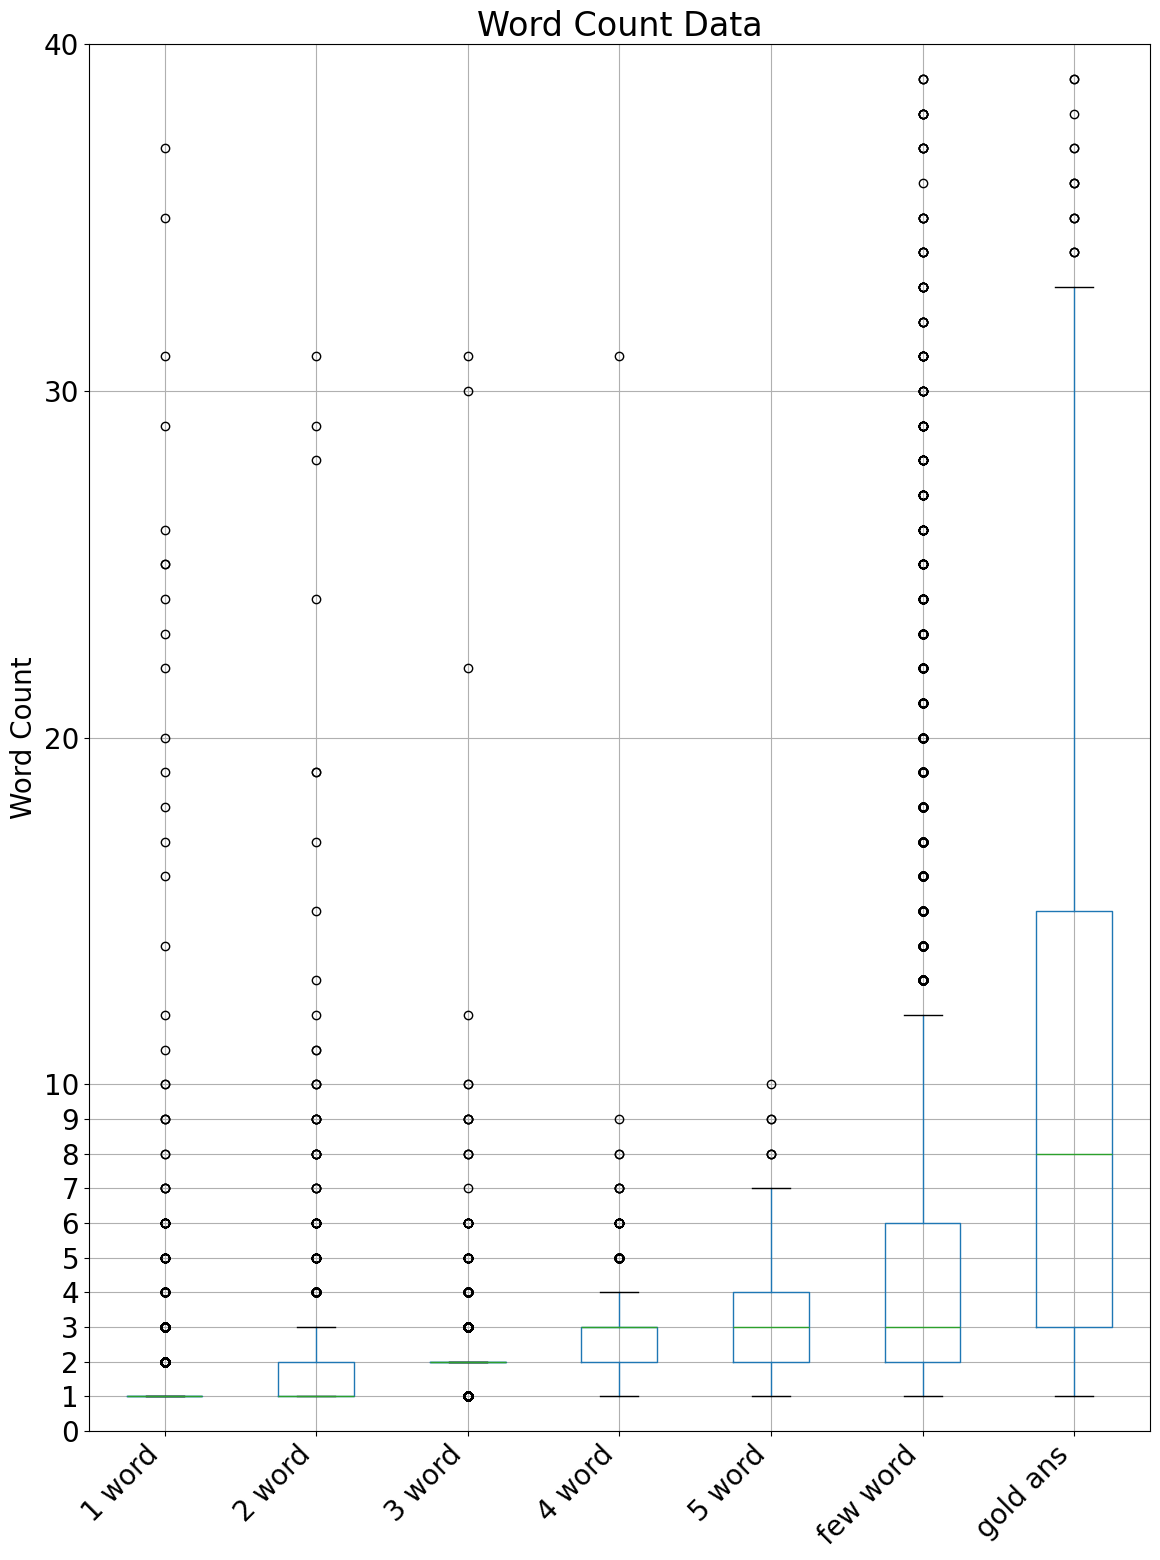

In [59]:
def plot_box_plot(data, title, ylabel, y_ticks=None, y_lim=None):
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize=(12, 16))  # Increased height for better visualization
    
    # Filter out extreme outliers more aggressively for better visualization
    data_filtered = data.apply(lambda x: x[np.abs(x - x.mean()) <= (2 * x.std())])

    data_filtered.T.boxplot(ax=ax)
    
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if y_ticks:
        ax.set_yticks(y_ticks)
    if y_lim:
        ax.set_ylim(y_lim)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_box_plot(word_count_for_plot, 'Word Count Data', 'Word Count', y_ticks=list(np.arange(0, 10, 1)) + list(np.arange(10, 61, 10)), y_lim=(0, 40))

In [31]:
import pandas as pd

# Load the merged DataFrame
merged_df = pd.read_csv('data_samples/paragraph-questions-100-short-answers.csv')

# Define a threshold for low rating scores
low_rating_threshold = 3

# Create a function to filter and format data for each answer length
def filter_low_ratings(df, answer_length):
    return df[df[f'{answer_length}_answer_rating_score'] < low_rating_threshold][[
        'context', 'text_cleaned', 'text_question',
        f'{answer_length}_answer_text', f'{answer_length}_answer_rating_score', f'{answer_length}_answer_rating_rationale'
    ]].rename(columns={
        f'{answer_length}_answer_text': 'answer_text',
        f'{answer_length}_answer_rating_score': 'rating_score',
        f'{answer_length}_answer_rating_rationale': 'rating_rationale'
    }).assign(answer_length=answer_length.replace('_', ' ').capitalize())

# List of answer lengths to check
answer_lengths = ['1_word', '2_words', '3_words', '4_words', '5_words', 'few_words']

# Concatenate all the filtered DataFrames
low_ratings_samples = pd.concat([filter_low_ratings(merged_df, length) for length in answer_lengths], ignore_index=True)

# Optionally, save the filtered samples to a CSV for further inspection
low_ratings_samples.to_csv('data_samples/low_ratings_samples.csv', index=False)

low_ratings_samples

,context,text_cleaned,text_question,answer_text,rating_score,rating_rationale,answer_length
0,In an article about 'Chimes of Freedom ( song ...,""" Chimes of Freedom "" is one of seven Dylan so...",Which Bob Dylan song was rearranged for sopran...,"""Chimes""",2.0,"The answer `""Chimes""` is partially correct bec...",1 word
1,"In an article about 'The Pale Emperor', sectio...","All lyrics written by Marilyn Manson , all mus...","Who wrote all the lyrics for ""The Pale Emperor""?",Marilyn,2.0,"The answer ""Marilyn"" is partially correct beca...",1 word
2,"In an article about 'St. Johns River', section...",Marjorie Kinnan Rawlings used the St. Johns as...,Which two books by Marjorie Kinnan Rawlings fe...,South,2.0,"The answer provided, ""South"", is partially cor...",1 word
3,"In an article about 'Don 't Bother', section '...",""" Don 't Bother "" was written by Shakira and A...","Who wrote ""Don't Bother"" along with Shakira?",Matrix.,2.0,"The answer ""Matrix"" is partially correct becau...",1 word
4,"In an article about 'Israeli cuisine', section...","Ashkenazi dishes include chicken soup , schnit...",What type of dishes do Ashkenazi Jews typicall...,Ashkenazi.,1.0,"The answer ""Ashkenazi"" is significantly incorr...",1 word
5,"In an article about 'Chinua Achebe', section '...","In October 2012 , Achebe 's publishers , Pengu...",Which event in Nigerian history did the public...,War.,2.0,"The answer ""War"" is partially correct, but it ...",1 word
6,"In an article about 'Pathala Bhairavi', sectio...",Krishna Kumari as an Angel,Which actress played the role of an Angel in P...,Krishna,2.0,"The answer ""Krishna"" is partially correct beca...",1 word
7,"In an article about '2003 Insight Bowl', secti...",The California Golden Bears earned a 7 - 5 rec...,What was the outcome of the 2002 Big Game betw...,Victory.,2.0,"The answer ""Victory"" is partially correct beca...",1 word
8,"In an article about 'Edward II of England', se...",The famine and the Scottish policy were felt t...,What aspect of Edward II of England's behavior...,Behavior.,2.0,"The answer ""Behavior"" is partially correct, as...",1 word
9,"In an article about 'William Murray , 1st Earl...",Mansfield spent the remainder of his life at K...,"On what date was William Murray, 1st Earl of M...",August,2.0,"The answer ""August"" is partially correct becau...",1 word
